In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold
import nltk
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Loading the dataset
news_train = pd.read_csv(
    "/Users/mohammadanas/Desktop/Duke MIDS/Fall 2021/NLP/NLP Final Project/data/Fake_news_data.csv"
)


In [5]:
# We just conduct EDA and go over the dataset as whole and 
# see if there are any flaws in the structure that need to be corrected 
# We make a copy of the data and make a perform some analysis
# After doing some preprocessing steps we note that these data entries have no text available 
# We filter out the IDS of these data entries 


news_train_eda = news_train.copy()
news_train_eda['text'] = news_train_eda['text'].str.lower()
news_train_eda['text'] = news_train_eda['text'].replace('[^A-Za-z\s]','', regex=True)
news_train_eda['text'] = news_train_eda['text'].str.split()
ids = list(news_train_eda.loc[news_train_eda['text'].str.len() == 0 ,]['id'])
news_train_eda.loc[news_train['id'].isin(ids)]

,id,title,author,text,label
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,[],1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,[],1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,[],1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,[],1
492,492,Казахстан на страже ядерной безопасности | Нов...,NaN,[],1
...,...,...,...,...,...
20141,20141,Thomas Frank Explores Whether Hillary Clinton ...,NaN,[],1
20242,20242,Radio Derb Transcript For October 21 Up: The M...,John Derbyshire,[],1
20264,20264,Pro-sovereignty Legislators Demand That Admini...,Brenda Walker,[],1
20513,20513,SAID IN SPANISH: A Mexican Governor Meddles In...,Allan Wall,[],1


In [6]:
# However, the text column above is a copy of a generated data with 
# some proprocessing steps already performed on it
# We use those IDs to get an idea of how the actual data entries of this data looks like
# We see that either there are no ids or there are the text is not in English language
news_train.loc[news_train['id'].isin(ids)] 

,id,title,author,text,label
82,82,Huma’s Weiner Dogs Hillary,Steve Sailer,,1
169,169,Mohamad Khweis: Another “Virginia Man” (Palest...,James Fulford,,1
295,295,A Connecticut Reader Reports Record Voter Regi...,VDARE.com Reader,,1
470,470,BULLETIN: There ARE Righteous Jews For Trump!;...,admin,,1
492,492,Казахстан на страже ядерной безопасности | Нов...,NaN,В ноябре 2016 г. Мажилис Парламента Республики...,1
...,...,...,...,...,...
20141,20141,Thomas Frank Explores Whether Hillary Clinton ...,NaN,,1
20242,20242,Radio Derb Transcript For October 21 Up: The M...,John Derbyshire,,1
20264,20264,Pro-sovereignty Legislators Demand That Admini...,Brenda Walker,,1
20513,20513,SAID IN SPANISH: A Mexican Governor Meddles In...,Allan Wall,,1


In [7]:
# To resolve this we replace the "text" of the sentences we our "title"
news_train.loc[news_train["id"].isin(ids), "text"] = news_train.loc[
    news_train["id"].isin(ids), "title"
]


In [8]:
# We only use the first 15000 rows to generate a train data set. This will include the train test split.
# The rest 5800 rows, we keep that as unseen data to check how well the model is actually performing.
news_train = news_train.iloc[:14999,:] # we filter the first 15000 rows

In [9]:
# Now that we have our data ready we perform preprocessing steps on it
news_train = news_train.dropna()  # place this above the two cells
label = news_train["label"]  # Get a seperate columns for labels
news_train = news_train.drop("label", axis=1)
news_train.set_index("id", inplace=True)


news_train["text"] = news_train[
    "text"
].str.lower()  # convert the whole text to lower case to ensure uniformity

news_train["text"] = news_train["text"].replace("[^A-Za-z\s]", "", regex=True)
#Replace everything that is not letters or a space with a blank

news_train["text"] = news_train["text"].str.split()  # split our text column to a list

In [10]:
# during this chunk cell, we just wrote a function to remove stopwords
# and use porterstemmer to perform lemmatization. This function takes in a list and return a sentence

ps = PorterStemmer()
nltk.download("stopwords")


def remove_stopwords_and_stem(x):
    stopwds_lst = stopwords.words("english")
    sentence = ""
    for i in x:
        if i in stopwds_lst:
            x.remove(i)
    for k in range(len(x)):
        word = ps.stem(x[k])
        x[k] = word
    for j in x:
        sentence = sentence + j + " "
    sentence_final = sentence[:-1]
    return sentence_final


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mohammadanas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
news_train['text'] = news_train['text'].apply(remove_stopwords_and_stem)
# we apply the above function to the text column

In [12]:
text_comments = news_train['text'] 
# now we seperate the text into another series 

In [13]:
# We create a Bag of words model that take into account the the most frequently occurring unigrams and bigrams. 
# The reason for doing this is avoiding curse of dimensionality  
cv = CountVectorizer(max_features=10000, ngram_range=(1,2)) 
cv.fit(text_comments) 
BOG = cv.transform(text_comments)
BOG = BOG.toarray() # seperate BOG(bag of words as a seperate array)
label = np.array(label) # seperate labels as an array

In [14]:
# in the next cell we train the model and tune the hyperparameter with k-fold cross validation
alphas = []
avg_acc = []              # make placeholders for evaluation metrics
avg_rec = []
avg_f1 = []
cr_val = KFold(5)
for alpha in np.arange(0.1,2,0.1): # loop over all the alphas 

  alphas.append(alpha) 
  
  acc = []
  rec = []
  f1 = []
  for train_index, test_index in cr_val.split(BOG): #get indexes of train test split
    
    x_train = BOG[train_index]
    x_test = BOG[test_index]
    y_train = label[train_index]           # make our train and test data based on the indexes
    y_test = label[test_index]
    classifier = MultinomialNB(alpha=alpha)   # fit the model 
    classifier.fit(x_train, y_train)
    pred = classifier.predict(x_test)             #make predictions
    score_a = metrics.accuracy_score(y_test, pred)
    score_f = metrics.f1_score(y_test, pred)
    score_r = metrics.recall_score(y_test, pred)       #calculate evaluation metrics
    acc.append(score_a)              #append the evaluation metrics to a list for each alpha for each train-test
    f1.append(score_f)
    rec.append(score_r)

    
  avg_a= np.mean(acc)
  avg_acc.append(avg_a)          # take the average of the evaluation metrics across all train-test splits for each alpha

  avg_r= np.mean(rec)
  avg_rec.append(avg_r)

  avg_f= np.mean(f1)
  avg_f1.append(avg_f)

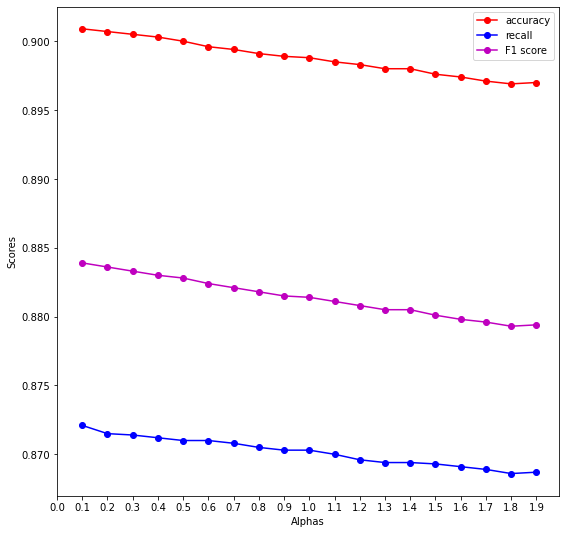

In [17]:
#Make a graph of all evaluation metrics for each alpha 
alphas = np.around(alphas,2)
avg_acc = np.around(avg_acc,4)
avg_rec = np.around(avg_rec,4)                     
avg_f1 = np.around(avg_f1,4)
plt.plot(alphas, avg_acc, marker='o', color='r', label= "accuracy")
plt.plot(alphas, avg_rec, marker='o', color='b', label = "recall")
plt.plot(alphas, avg_f1, marker='o', color='m', label="F1 score" )
plt.xlabel("Alphas")
plt.ylabel("Scores")
plt.xticks(np.arange(0,2,0.1))
plt.rcParams["figure.figsize"] = (9,9)
plt.legend(loc='upper right')
plt.show()

In [18]:
# We choose alpha as 0.1 as it returns the highest accuracy 
# and we do not overfit with higher alpha value. and train our model on that

In [19]:
# fit a final model for all the train data set based on the chosen hyperparameters
Final_Model = MultinomialNB(alpha=0.1)
Final_Model.fit(BOG, label)


MultinomialNB(alpha=0.1)

In [20]:
# save the models to test them on the entirely new data
import pickle
# save Naive Bayes
pickle.dump(
    Final_Model,
    open(
        "/Users/mohammadanas/Desktop/Duke MIDS/Fall 2021/NLP/NLP Final Project/NB_model.pkl",
        "wb",
    ),
)

# save count vectorizer
pickle.dump(
    cv,
    open(
        "/Users/mohammadanas/Desktop/Duke MIDS/Fall 2021/NLP/NLP Final Project/CV_BOG.pkl",
        "wb",
    ),
)
